In [77]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [93]:
import os
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [78]:
import numpy as np
image_dataset = np.load('/content/drive/MyDrive/train_X/image_dataset.npy',allow_pickle=True)*-1
ground_truth = np.load('/content/drive/MyDrive/train_Y/groud_dataset.npy',allow_pickle=True)*-1

In [79]:
image_dataset = image_dataset[0:300,:,:]
ground_truth = ground_truth[0:300,:,:]

In [80]:
image_dataset_max = np.max(image_dataset)
ground_truth_max = np.max(ground_truth)
image_dataset_min = np.min(image_dataset)
ground_truth_min = np.min(ground_truth)

In [81]:
image_dataset = image_dataset/image_dataset_max
ground_truth =  ground_truth/ground_truth_max

In [82]:
def replace_nan_with_mean(dataset):
    nan_mask = np.isnan(dataset)
    non_nan_values = dataset[~nan_mask]
    mean_value = np.mean(non_nan_values)
    dataset[nan_mask] = mean_value
    return dataset

In [83]:
#X_train
from sklearn.model_selection import train_test_split
image_dataset[image_dataset == -np.inf] = np.min(image_dataset[np.isfinite(ground_truth)])
image_dataset = replace_nan_with_mean(image_dataset)

ground_truth[ground_truth == -np.inf] = np.min(ground_truth[np.isfinite(ground_truth)])
ground_truth = replace_nan_with_mean(ground_truth)


In [84]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(image_dataset, ground_truth, test_size = 0.1, random_state = 0)

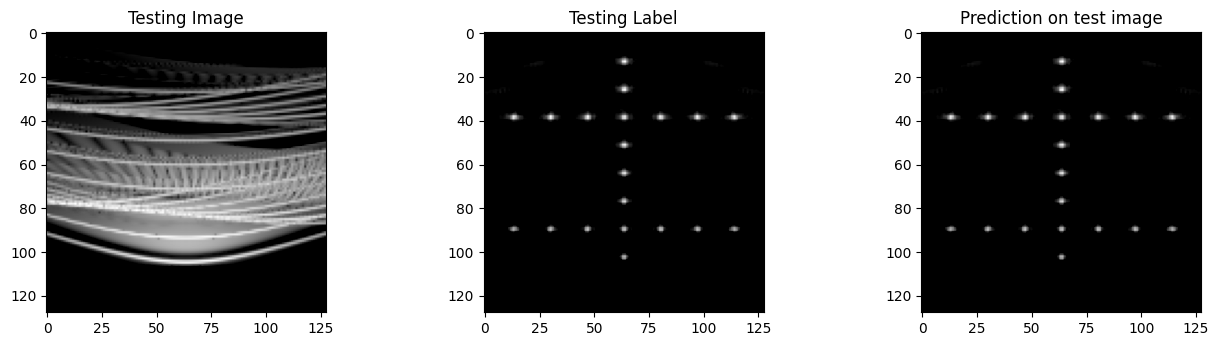

In [85]:
rand_number=225
input = np.squeeze(image_dataset[rand_number]*image_dataset_max*-1)
prediction= np.squeeze(ground_truth[rand_number]*ground_truth_max*-1)
ground = np.squeeze(ground_truth[rand_number]*ground_truth_max*-1)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(input, vmin=-60, cmap="gray", origin="upper")
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(ground, vmin=-60, cmap="gray", origin="upper")
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(prediction, vmin=-60, cmap="gray", origin="upper")

plt.show()

In [ ]:
# Add channel dimension and convert to float32
X_train = X_train[..., tf.newaxis]  # Add channel dimension
X_test = X_test[..., tf.newaxis]

y_train = y_train[..., tf.newaxis]  # Add channel dimension
y_test = y_test[..., tf.newaxis]

In [90]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Model

# Generator model
def build_generator(input_shape):
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    # Decoder
    x = Conv2DTranspose(64, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    outputs = Conv2D(1, (7, 7), activation='tanh', padding='same')(x)  # Output image

    generator = Model(inputs, outputs)
    return generator

# Discriminator model
def build_discriminator(input_shape):
    inputs = Input(shape=input_shape)

    x = Conv2D(64, (4, 4), strides=(2, 2), padding='same')(inputs)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(128, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(256, (4, 4), strides=(2, 2), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    x = Conv2D(512, (4, 4), padding='same')(x)
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.2)(x)

    outputs = Conv2D(1, (4, 4), activation='sigmoid', padding='same')(x)  # Binary classification

    discriminator = Model(inputs, outputs)
    return discriminator

# Define image shapes and models
input_shape = (128, 128, 1)
gen_AB = build_generator(input_shape)
gen_BA = build_generator(input_shape)
disc_A = build_discriminator(input_shape)
disc_B = build_discriminator(input_shape)


In [94]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy, MeanAbsoluteError
from sklearn.model_selection import train_test_split

# Define optimizers and loss functions
gen_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.legacy.Adam(learning_rate= 1e-4, beta_1=0.5)
binary_crossentropy = BinaryCrossentropy(from_logits=True)
mean_absolute_error = MeanAbsoluteError()

# Training loop
num_epochs = 200
batch_size = 4


# Create TensorFlow Datasets from the splits
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(len(X_train)).batch(batch_size)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(batch_size)



In [ ]:

for epoch in range(num_epochs):
    for batch_A, batch_B in train_dataset:
        with tf.GradientTape(persistent=True) as tape:
            # Generator loss
            fake_B = gen_AB(batch_A, training=True)
            cycle_A = gen_BA(fake_B, training=True)

            fake_A = gen_BA(batch_B, training=True)
            cycle_B = gen_AB(fake_A, training=True)

            identity_A = gen_BA(batch_A, training=True)
            identity_B = gen_AB(batch_B, training=True)

            gen_loss = (
                binary_crossentropy(disc_B(fake_B), tf.ones_like(disc_B(fake_B))) +
                binary_crossentropy(disc_A(fake_A), tf.ones_like(disc_A(fake_A))) +
                10 * mean_absolute_error(batch_A, cycle_A) +
                10 * mean_absolute_error(batch_B, cycle_B) +
                5 * mean_absolute_error(batch_A, identity_A) +
                5 * mean_absolute_error(batch_B, identity_B)
            )

            # Discriminator loss
            disc_A_loss = (
                binary_crossentropy(disc_A(batch_A), tf.ones_like(disc_A(batch_A))) +
                binary_crossentropy(disc_A(fake_A), tf.zeros_like(disc_A(fake_A)))
            )

            disc_B_loss = (
                binary_crossentropy(disc_B(batch_B), tf.ones_like(disc_B(batch_B))) +
                binary_crossentropy(disc_B(fake_B), tf.zeros_like(disc_B(fake_B)))
            )

        # Calculate gradients and update weights
        gen_gradients = tape.gradient(gen_loss, gen_AB.trainable_variables + gen_BA.trainable_variables)
        disc_A_gradients = tape.gradient(disc_A_loss, disc_A.trainable_variables)
        disc_B_gradients = tape.gradient(disc_B_loss, disc_B.trainable_variables)

        gen_optimizer.apply_gradients(zip(gen_gradients, gen_AB.trainable_variables + gen_BA.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_A_gradients, disc_A.trainable_variables))
        disc_optimizer.apply_gradients(zip(disc_B_gradients, disc_B.trainable_variables))



        print(f"Epoch {epoch+1}/{num_epochs}, Gen loss: {gen_loss}, Disc A loss: {disc_A_loss}, Disc B loss: {disc_B_loss}")

    if (epoch + 1) % 10 == 0:
         # Save model checkpoints
        checkpoint_dir = "checkpoints"
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        checkpoint = tf.train.Checkpoint(
            gen_AB_optimizer=gen_optimizer,
            gen_BA_optimizer=gen_optimizer,
            disc_A_optimizer=disc_optimizer,
            disc_B_optimizer=disc_optimizer,
            gen_AB=gen_AB,
            gen_BA=gen_BA,
            disc_A=disc_A,
            disc_B=disc_B
        )
        checkpoint.save(file_prefix=checkpoint_prefix)

Epoch 1/200, Gen loss: 1.3309686183929443, Disc A loss: 1.0064111948013306, Disc B loss: 1.0064117908477783
Epoch 1/200, Gen loss: 3.158889055252075, Disc A loss: 1.0064104795455933, Disc B loss: 1.0064098834991455
Epoch 1/200, Gen loss: 2.066145658493042, Disc A loss: 1.0064103603363037, Disc B loss: 1.0064119100570679
Epoch 1/200, Gen loss: 1.8076115846633911, Disc A loss: 1.0064098834991455, Disc B loss: 1.0064101219177246
Epoch 1/200, Gen loss: 1.812450885772705, Disc A loss: 1.0064103603363037, Disc B loss: 1.0064107179641724
Epoch 1/200, Gen loss: 1.649600625038147, Disc A loss: 1.006411075592041, Disc B loss: 1.0064103603363037
Epoch 1/200, Gen loss: 1.4969340562820435, Disc A loss: 1.006410002708435, Disc B loss: 1.0064101219177246
Epoch 1/200, Gen loss: 1.4914995431900024, Disc A loss: 1.0064094066619873, Disc B loss: 1.0064096450805664
Epoch 1/200, Gen loss: 1.2790966033935547, Disc A loss: 1.0064094066619873, Disc B loss: 1.0064096450805664
Epoch 1/200, Gen loss: 1.546926021

In [61]:
# Validation loop
for batch_A_val, batch_B_val in test_dataset:
    with tf.GradientTape(persistent=True) as tape:
        # Generator loss for validation
        fake_B_val = gen_AB(batch_A_val, training=False)
        cycle_A_val = gen_BA(fake_B_val, training=False)

        fake_A_val = gen_BA(batch_B_val, training=False)
        cycle_B_val = gen_AB(fake_A_val, training=False)

        identity_A_val = gen_BA(batch_A_val, training=False)
        identity_B_val = gen_AB(batch_B_val, training=False)

        gen_loss_val = (
            binary_crossentropy(disc_B(fake_B_val), tf.ones_like(disc_B(fake_B_val))) +
            binary_crossentropy(disc_A(fake_A_val), tf.ones_like(disc_A(fake_A_val))) +
            10 * mean_absolute_error(batch_A_val, cycle_A_val) +
            10 * mean_absolute_error(batch_B_val, cycle_B_val) +
            5 * mean_absolute_error(batch_A_val, identity_A_val) +
            5 * mean_absolute_error(batch_B_val, identity_B_val)
        )

        # Discriminator loss for validation
        disc_A_loss_val = (
            binary_crossentropy(disc_A(batch_A_val), tf.ones_like(disc_A(batch_A_val))) +
            binary_crossentropy(disc_A(fake_A_val), tf.zeros_like(disc_A(fake_A_val)))
        )

        disc_B_loss_val = (
            binary_crossentropy(disc_B(batch_B_val), tf.ones_like(disc_B(batch_B_val))) +
            binary_crossentropy(disc_B(fake_B_val), tf.zeros_like(disc_B(fake_B_val)))
        )

print(f"Validation - Gen loss: {gen_loss_val}, Disc A loss: {disc_A_loss_val}, Disc B loss: {disc_B_loss_val}")


Validation - Gen loss: 1.9449477195739746, Disc A loss: 1.6837162971496582, Disc B loss: 1.6475257873535156


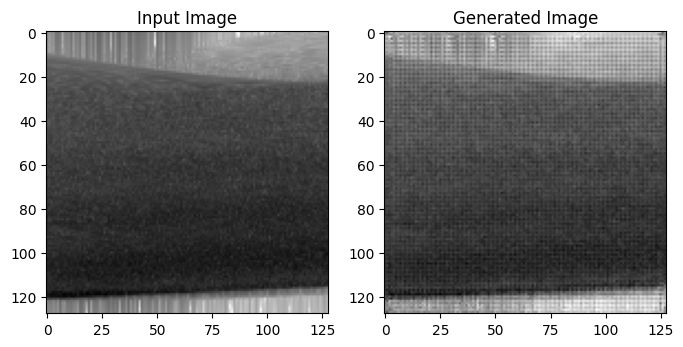

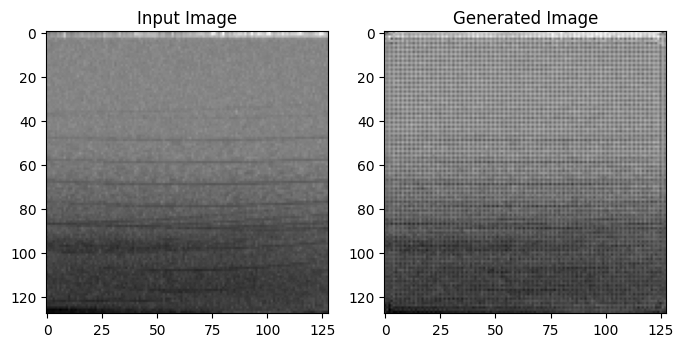

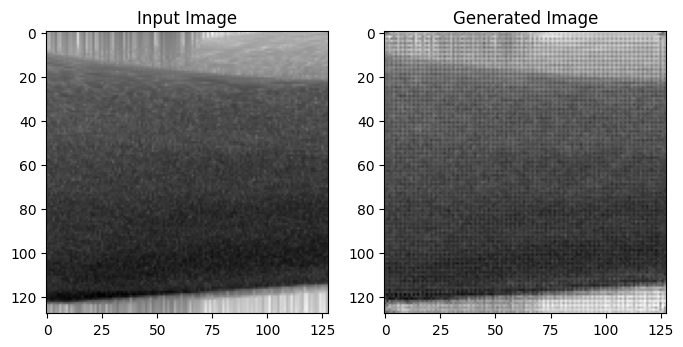

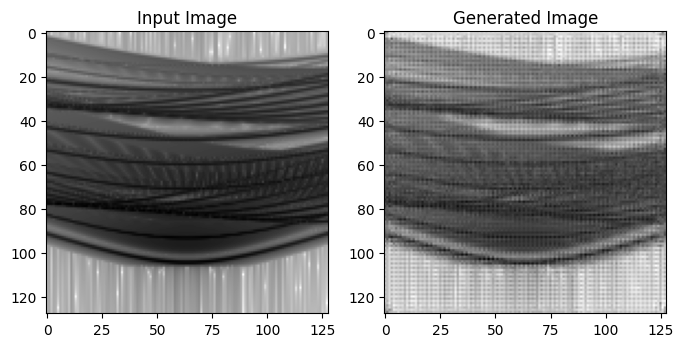

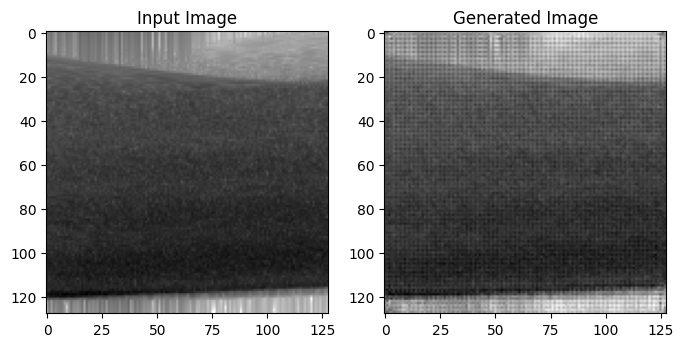

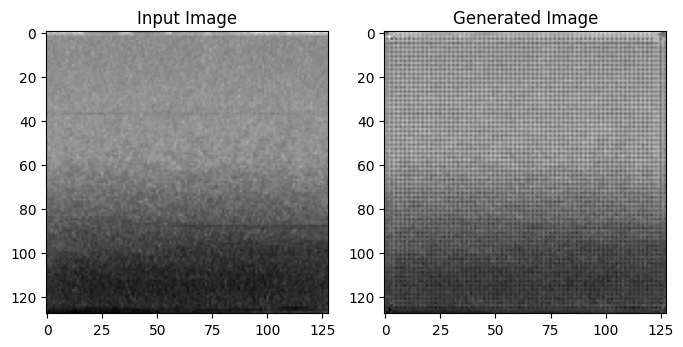

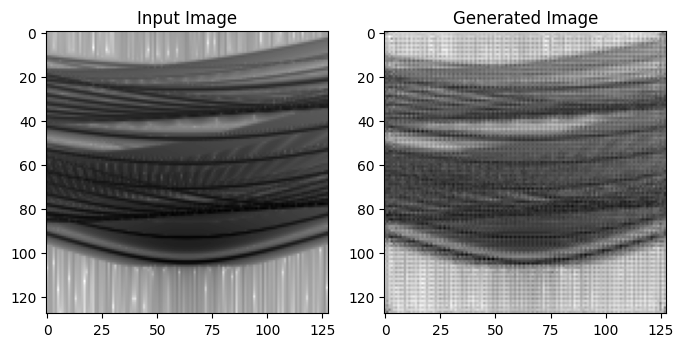

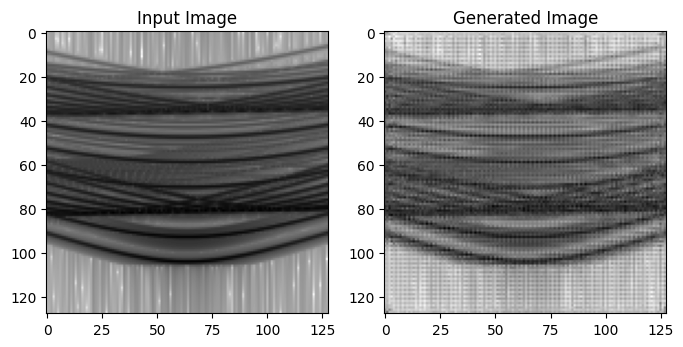

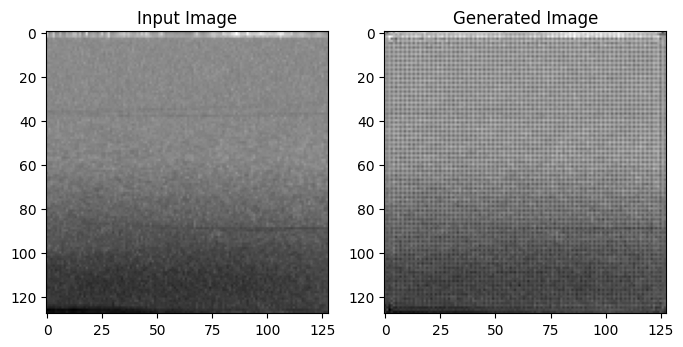

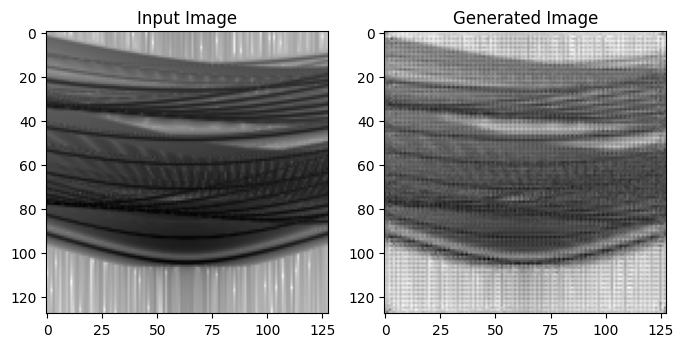

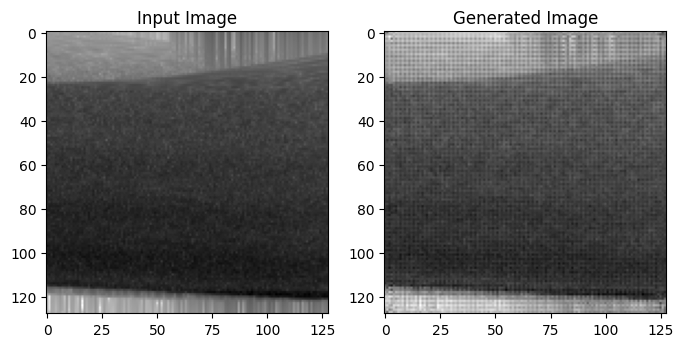

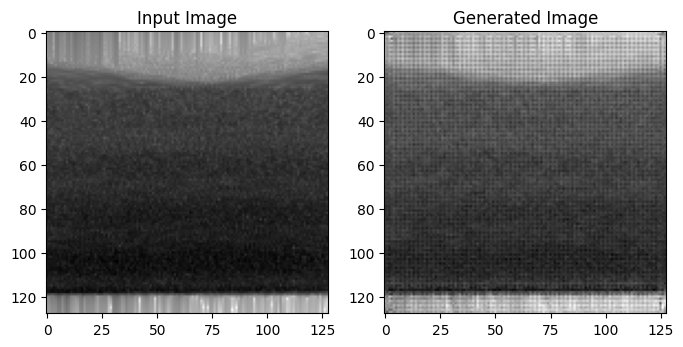

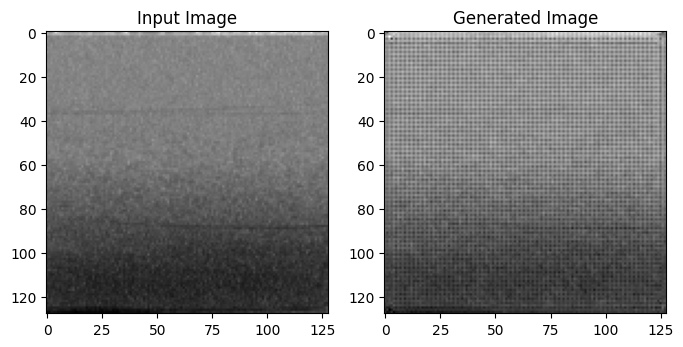

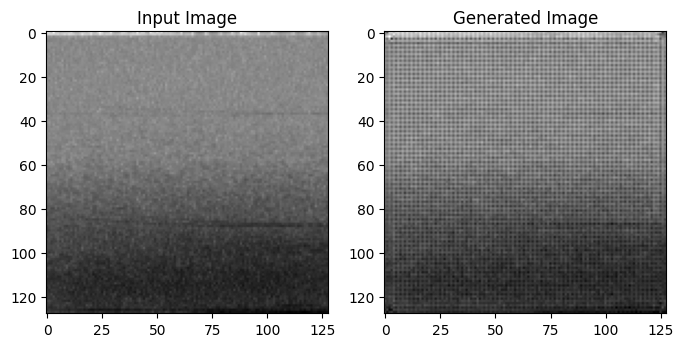

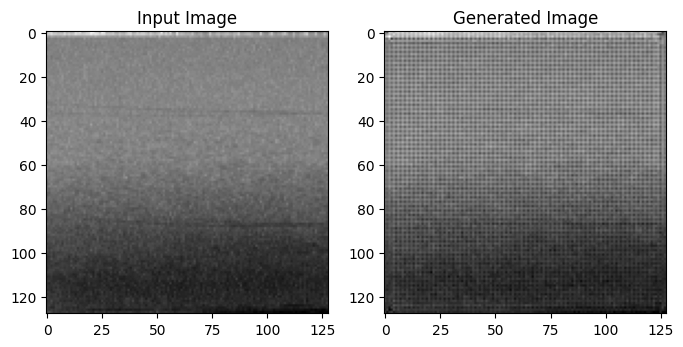

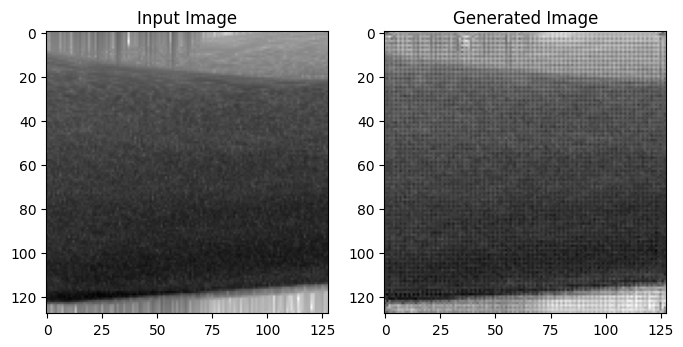

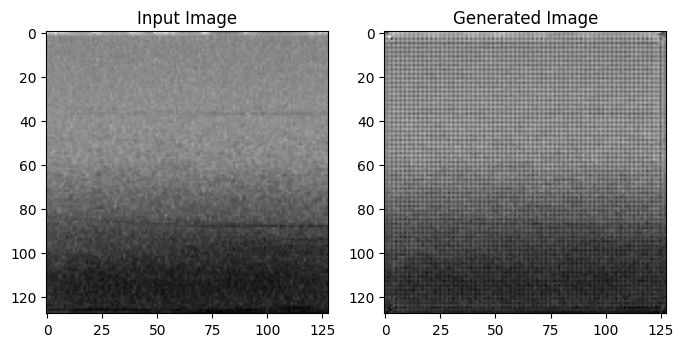

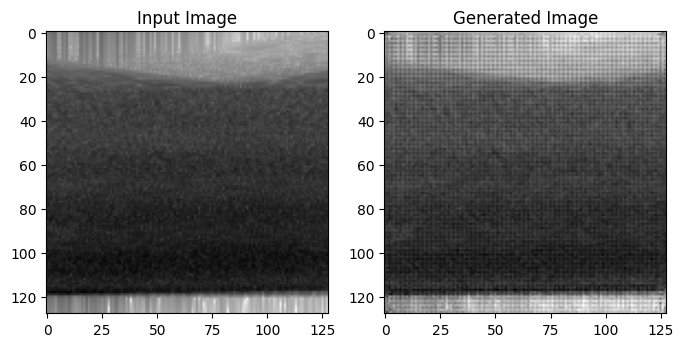

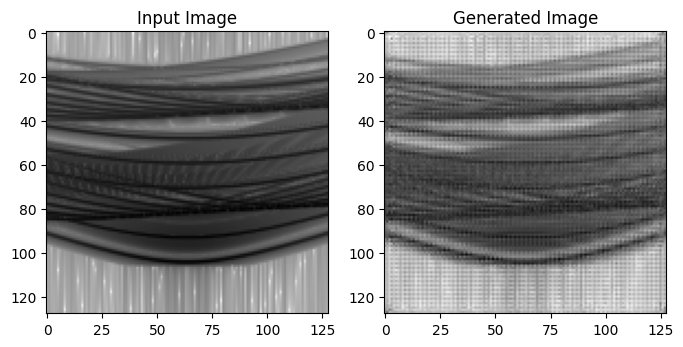

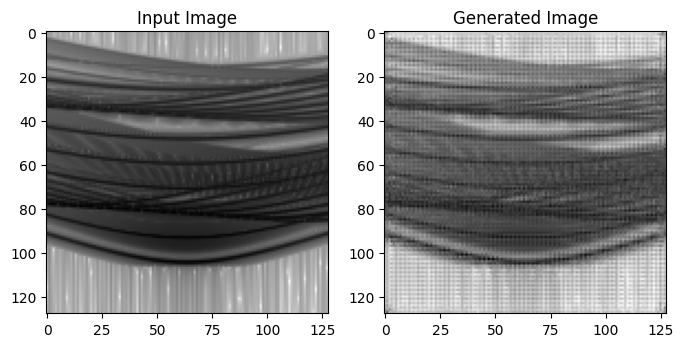

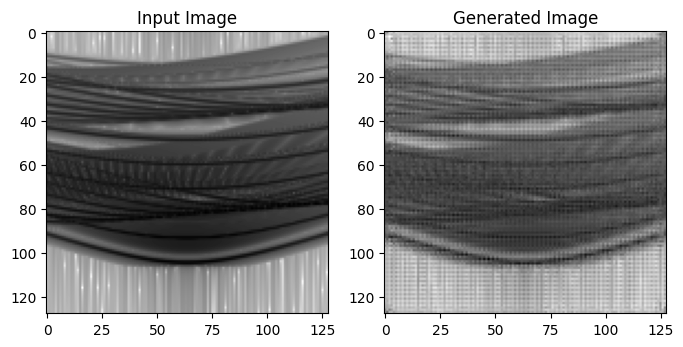

In [89]:
# Generate and show sample images
def generate_and_show_samples(generator, test_dataset):
    for batch_A, _ in test_dataset:
        generated_images = generator(batch_A, training=False)
        for i in range(generated_images.shape[0]):
            plt.figure(figsize=(8, 8))
            plt.subplot(1, 2, 1)
            plt.imshow(batch_A[i] * 0.5 + 0.5, cmap="gray", origin="upper")  # Unnormalize and display real image
            plt.title('Input Image')

            plt.subplot(1, 2, 2)
            plt.imshow(generated_images[i] * 0.5 + 0.5, cmap="gray", origin="upper")  # Unnormalize and display generated image
            plt.title('Generated Image')

            plt.show()

# Generate and show sample images using the generator
generate_and_show_samples(gen_AB, test_dataset)

In [ ]:
import pandas as pd
unet_history_df = pd.DataFrame(Unet.history)
with open('unet_history_df.csv', mode='w') as f:
    unet_history_df.to_csv(f)

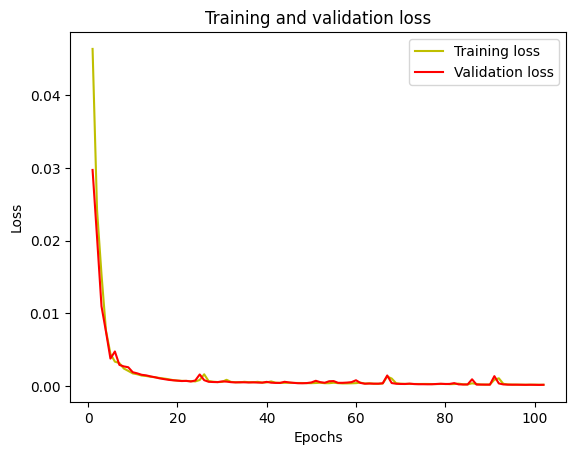

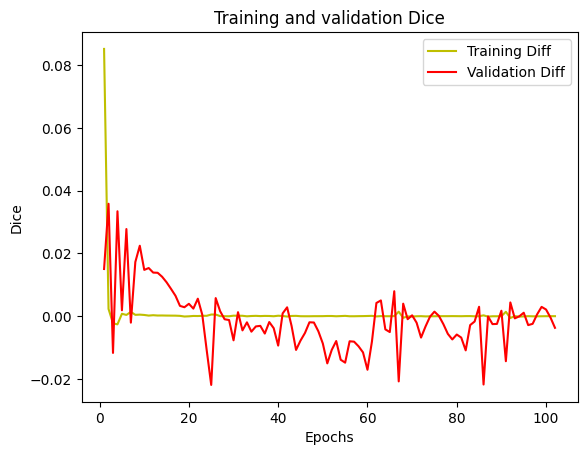

In [ ]:
#######################################################################
#Check history plots, one model at a time
history = Unet

#plot the training and validation accuracy and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['diff']
#acc = history.history['accuracy']
val_acc = history.history['val_diff']
#val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Diff')
plt.plot(epochs, val_acc, 'r', label='Validation Diff')
plt.title('Training and validation Dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()


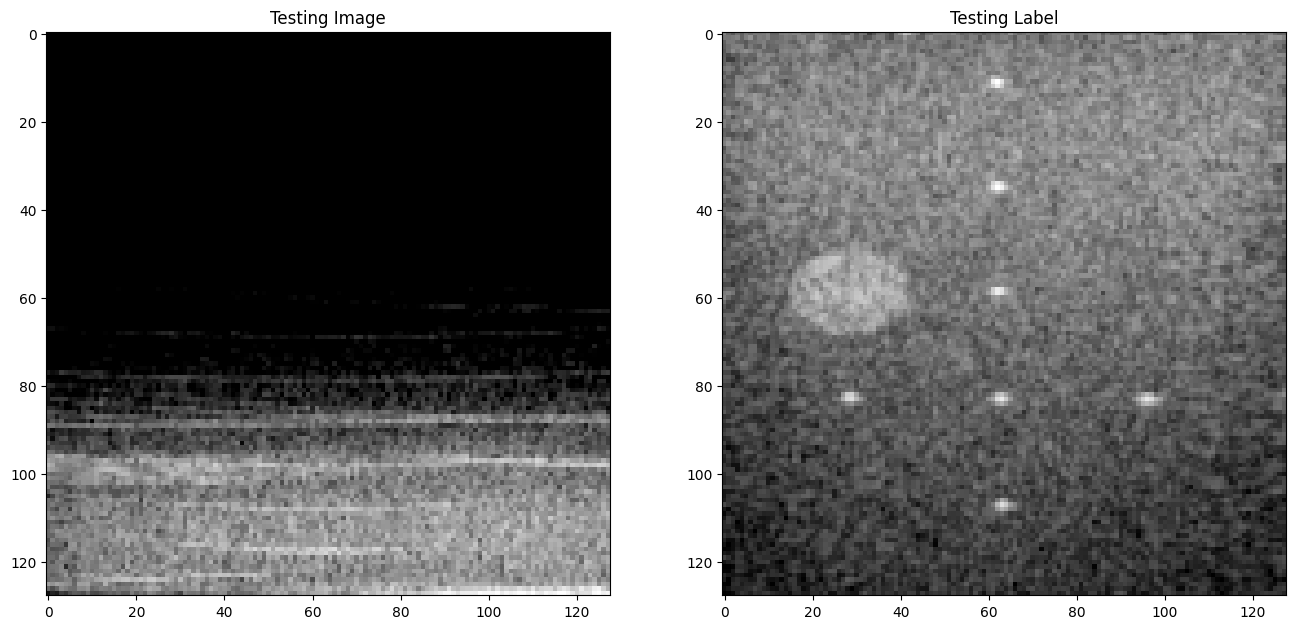

In [ ]:
rand_number=8
input = np.squeeze(X_test[rand_number]*image_dataset_max*-1)
ground = np.squeeze(y_test[rand_number]*ground_truth_max*-1)

import matplotlib.pyplot as plt

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title('Testing Image')
plt.imshow(input, vmin=-60, cmap="gray", origin="upper")
plt.subplot(122)
plt.title('Testing Label')
plt.imshow(ground, vmin=-60, cmap="gray", origin="upper")
plt.show()

In [ ]:

test_img = X_test[5]
ground_truth=y_test[5]*ground_truth_max*-1
test_img_input=np.expand_dims(test_img, 0)
prediction = np.squeeze((model.predict(test_img_input)))*image_dataset_max*-1

1/1 [==============================] - 0s 403ms/step


In [ ]:
print(np.mean(prediction-ground_truth))

-3.1097801007708767


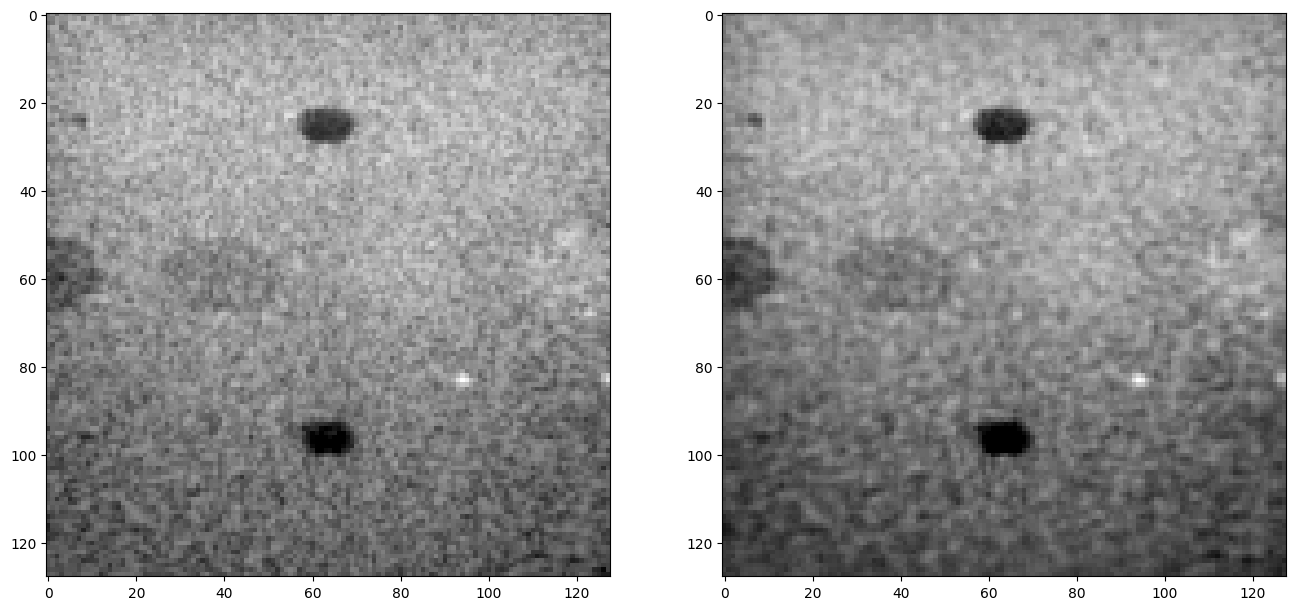

In [ ]:

plt.figure(figsize=(16,8))
plt.subplot(121)
plt.imshow(ground_truth, vmin=-60, cmap="gray", origin="upper")
plt.subplot(122)
plt.imshow(prediction, vmin=-60, cmap="gray", origin="upper")
plt.show()